##**MULTIRES-UNET ARCHITECTURE**

**IMPORTING LIBRARIES**

In [ ]:
# Required Packages

%tensorflow_version 2.1.0
!pip install segmentation-models==1.0.1

In [3]:
# Data Handling
import numpy as np
import os
import glob
import cv2
import random
import zipfile
from skimage import io
import imutils

# Visualization
from matplotlib import pyplot as plt
%matplotlib inline

# Data Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import get_file
from keras_applications import imagenet_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation

# Import Custom files
import unet_func_block
from unet_func_block import drop_out, conv_block, encoder_block, decoder_block_unet, build_unet, build_autoencoder, build_encoder, build_decoder

import pd_functions
from pd_functions import load_data, load_test_data, visualize, visualize_generated, preprocessing, preprocess_customUnet, data_split
from pd_functions import augment, augment32, model_IOU, iou_acc, evaluation, performance, testing, compare_evaluation_2, compare_evaluation_3
from pd_functions import compare_performance

import multiresunet_func_block
from multiresunet_func_block import conv_block, multires_block, res_path, encoder_block, decoder_block, build_multiresunet

sm.set_framework('tf.keras')
sm.framework()

2.8.0


'tf.keras'

#### ***COMPARISON OF MULTIRES-UNET WITH ORIGINAL UNET ARCHITECTURE***


*   MultiRes-Unet Architecture
*   Unet vs MultiRes Unet



In [4]:
### DIRECTORY

drive_path = '/content/drive/MyDrive/Colab Notebooks/'
saved_models = '/content/drive/MyDrive/Colab Notebooks/saved_models/'
Train_path = "/data/Train_folder/OriginalTrain"
Mask_path =  "/data/Train_folder/AnnotationsTrain"
test_path = "/testdata/Testers"

### HYPER-PARAMETERS

# (Data Dynamics)
size = 256
IMG_CHANNELS = 3
input_shape = (size, size, IMG_CHANNELS)

# (Model Parameters)
iou = sm.metrics.iou_score
jaccard_loss = sm.losses.bce_jaccard_loss
binary_loss = 'binary_crossentropy'
optimizer = 'Adam'

# (Batch Sizes)
BS16 = 16                            
BS32 = 32

In [5]:
# Loading Image Directory

zip_ref = zipfile.ZipFile(f'{drive_path}Train_folder.zip', 'r')
zip_ref.extractall('/data')
zip_ref.close()

In [6]:
# Loading Test Directory

zip_ref = zipfile.ZipFile(f'{drive_path}Testers.zip', 'r')
zip_ref.extractall('/testdata')
zip_ref.close()

In [7]:
# Loading Data
train_images, mask_images = load_data(Train_path, Mask_path, size)

print(train_images.shape)
print(mask_images.shape)

(472, 256, 256, 3)
(472, 256, 256)


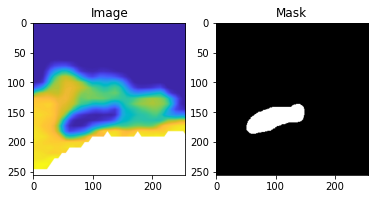

Labels are: [0 1] and label count is: [62581  2955]
Image Number= 469


In [8]:
# Visualization before preprocessing

img_num = random.randint(0, len(train_images)-1)
V = visualize(train_images, mask_images, img_num)
V

In [9]:
# Preprocessing

X, Y = preprocess_customUnet(train_images,mask_images)

print(X.shape)
print(Y.shape)

(472, 256, 256, 3)
(472, 256, 256, 1)


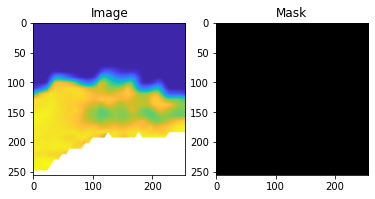

Labels are: [0.] and label count is: [65536]
Image Number= 139


In [10]:
# Visualizing Preprocessed images

img_num = random.randint(0, len(X)-1)
VP = visualize(X,Y, img_num)
VP

In [11]:
# Data Split

x_train, y_train, x_val, y_val = data_split(X, Y, split_size = 0.2, random_state = 42)

print("Train Data Dynamics:" , x_train.shape, y_train.shape)
print("Test Data Dynamics:" , x_val.shape, y_val.shape)

Train Data Dynamics: (377, 256, 256, 3) (377, 256, 256, 1)
Test Data Dynamics: (95, 256, 256, 3) (95, 256, 256, 1)


**MultiRes Unet using Original Data Set (Batch Size= 16)**

In [12]:
# Building MultiRes UNET model

multires = build_multiresunet(input_shape)
multires.compile(optimizer='adam', loss= binary_loss, metrics=[iou])

history_mr_orig = multires.fit(x=x_train, y= y_train, batch_size= BS16, 
                                    epochs= 100, verbose=1, validation_data= (x_val, y_val))

Epoch 1/100
24/24 [==============================] - 63s 1s/step - loss: 0.6526 - iou_score: 0.0168 - val_loss: 0.6215 - val_iou_score: 0.0117
Epoch 2/100
24/24 [==============================] - 20s 855ms/step - loss: 0.4885 - iou_score: 0.0224 - val_loss: 24.8610 - val_iou_score: 0.0123
Epoch 3/100
24/24 [==============================] - 21s 866ms/step - loss: 0.3580 - iou_score: 0.0279 - val_loss: 23.0040 - val_iou_score: 0.0132
Epoch 4/100
24/24 [==============================] - 21s 879ms/step - loss: 0.2713 - iou_score: 0.0364 - val_loss: 0.7081 - val_iou_score: 0.0123
Epoch 5/100
24/24 [==============================] - 21s 896ms/step - loss: 0.1957 - iou_score: 0.0368 - val_loss: 22.6695 - val_iou_score: 0.0109
Epoch 6/100
24/24 [==============================] - 22s 904ms/step - loss: 0.1411 - iou_score: 0.0483 - val_loss: 11.0806 - val_iou_score: 0.0217
Epoch 7/100
24/24 [==============================] - 21s 894ms/step - loss: 0.0982 - iou_score: 0.0704 - val_loss: 1.1475 -

In [27]:
# Saving model and history
multires.save(f'{saved_models}multires_original.h5')

# Saving history
np.save(f'{saved_models}multires_orig_history.npy', history_mr_orig.history)

In [13]:
# Accuracy
accuracy = model_IOU(multires, x_val, y_val, 0.5)
print('IOU score of model "multires unet model" is', f'{accuracy:.0%}')

IOU score of model "multires unet model" is 82%


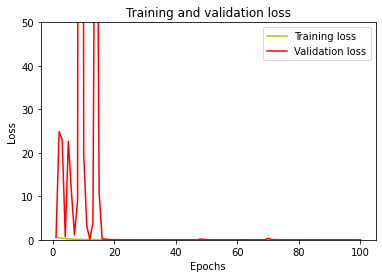

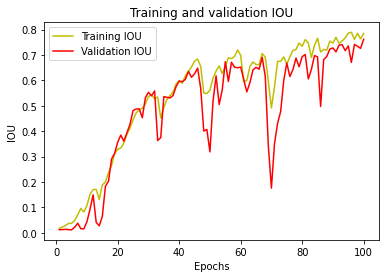

In [14]:
# Evaluation

EV = evaluation(history_mr_orig)

Image Number= 78


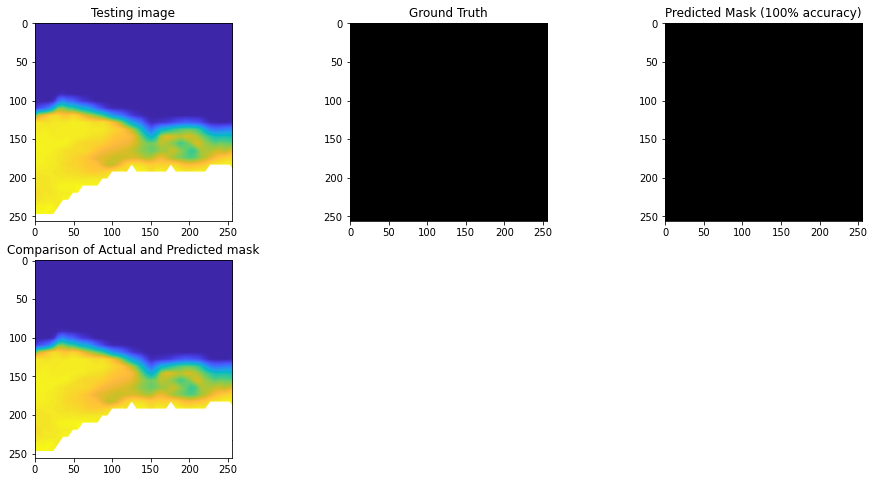

In [37]:
# Performance

img_num = random.randint(0, len(x_val)-1)
perf = performance(x_val, y_val, model = multires, threshold=0.8, test_img_number=img_num)

**COMPARISON OF UNET VS MULTIRES**

In [29]:
unet_original_history = np.load(f'{saved_models}custom_unet_original_history.npy',allow_pickle='TRUE').item()
multires_original_history = np.load(f'{saved_models}multires_orig_history.npy',allow_pickle='TRUE').item()

In [30]:
def compare_evaluation_2(history1, history2, model1, model2):

    val_acc1 = history1['val_iou_score']
    val_acc2 = history2['val_iou_score']
    epochs = range(1, len(val_acc1) +1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, val_acc1, label= f'{model1}', color = 'xkcd:blue')
    plt.plot(epochs, val_acc2, label=f'{model2}', color='xkcd:orange')
    plt.title('Comparison of Validation accuracy from two models')
    plt.xlabel('Epochs')
    plt.ylabel('IOU')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

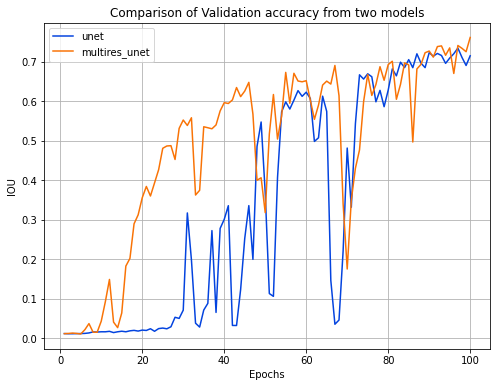

In [31]:
C1 = compare_evaluation_2(unet_original_history, multires_original_history, "unet", "multires_unet")

**COMPARISON OF PERFORMANCE**

In [38]:
# Load Models

unet_original = load_model(f'{saved_models}custom_unet_original.h5', compile=False)
multires_original = load_model(f'{saved_models}multires_original.h5', compile=False)

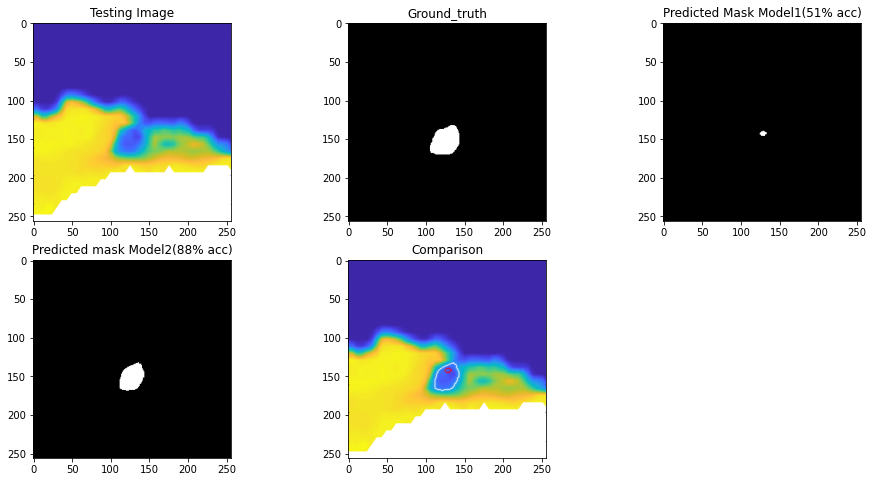

In [91]:
CP = compare_performance(x_val, y_val, unet_original, multires_original, 0.8)

#### ***EXPERIMENTING DATA AUGMENTATION***

In [ ]:
# Data Augmentation

train_generator, val_generator, trainImage_generated, trainMask_generated = augment32(X, Y, 0.2)

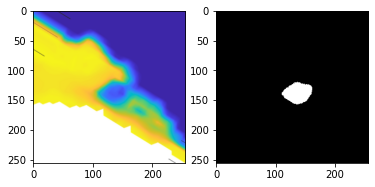

Labels [0. 1.]


In [ ]:
# Visualize generated images

VG = visualize_generated(trainImage_generated,trainMask_generated)

In [ ]:
#Building multires unet model with augmented data

multires_aug = build_multiresunet(input_shape)
multires_aug.compile(optimizer='adam', loss= jaccard_loss, metrics=[iou])
#multires.summary()

history_mr_aug = multires_aug.fit_generator(train_generator, validation_data= val_generator,
                                             steps_per_epoch= 20, validation_steps= 20, epochs= 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
20/20 [==============================] - 25s 812ms/step - loss: 1.6540 - iou_score: 0.0145 - val_loss: 1.6277 - val_iou_score: 0.0111
Epoch 2/100
20/20 [==============================] - 16s 816ms/step - loss: 1.5470 - iou_score: 0.0152 - val_loss: 1.5583 - val_iou_score: 0.0129
Epoch 3/100
20/20 [==============================] - 14s 715ms/step - loss: 1.4460 - iou_score: 0.0248 - val_loss: 1.4867 - val_iou_score: 0.0133
Epoch 4/100
20/20 [==============================] - 14s 699ms/step - loss: 1.3473 - iou_score: 0.0245 - val_loss: 11.1108 - val_iou_score: 0.0125
Epoch 5/100
20/20 [==============================] - 14s 702ms/step - loss: 1.2456 - iou_score: 0.0380 - val_loss: 1.3232 - val_iou_score: 0.0226
Epoch 6/100
20/20 [==============================] - 14s 700ms/step - loss: 1.1582 - iou_score: 0.0483 - val_loss: 1.2319 - val_iou_score: 0.0188
Epoch 7/100
20/20 [==============================] - 14s 708ms/step - loss: 1.0901 - iou_score: 0.0638 - val_loss: 1.1744 -

In [ ]:
# Accuracy
accuracy2 = model_IOU(multires_aug, x_val, y_val, 0.5)
print('IOU score of model "multires unet augmented model" is', f'{accuracy2:.0%}')

IOU score of model "multires unet augmented model" is 80%


In [ ]:
# saving model
multires_aug.save(f'{saved_models}multires_augmented.h5')

# saving history
np.save(f'{saved_models}multires_aug_history.npy', history_mr_aug.history)


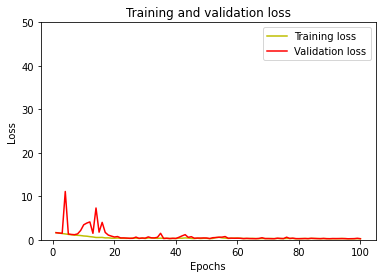

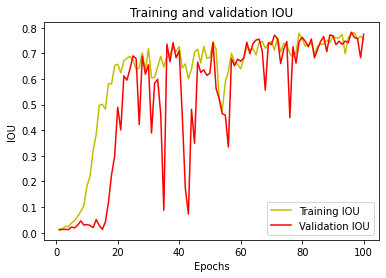

In [ ]:
# Evaluation

EV2 = evaluation(history_mr_aug)

**Comparison of Unet and MultiRes Unet with augmented data**

In [ ]:
# Loading history of unet
hist_unet = np.load(f'{saved_models}custom_unet_augmented_history.npy', allow_pickle='TRUE').item()
hist_multires = np.load(f'{saved_models}multires_aug_history.npy', allow_pickle='TRUE').item()

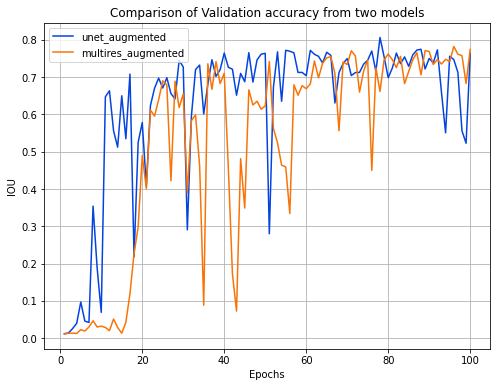

In [ ]:
# Compare History Evaluation

C1 = compare_evaluation_2(hist_unet, hist_multires, "unet_augmented", "multires_augmented")

**TESTING ON UNSEEN DATA**

In [54]:
# Testing on Unseen Data 

tester_img = load_test_data(test_path, size)
print(tester_img.shape)

(32, 256, 256, 3)


No Polynya Detected


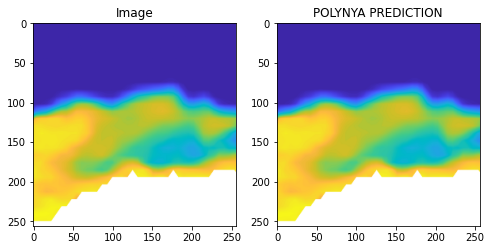

Image number: 12


In [122]:
# Performance of Multires-unet Model trained on Original Dataset

img_num = random.randint(0, len(tester_img)-1)
T2 = testing(tester_img, multires_original, 0.8, img_num)

No Polynya Detected


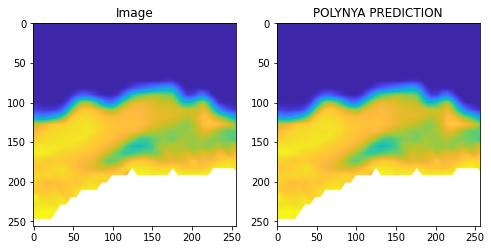

Image number: 27


In [121]:
# Performance of Unet Model trained on Original Dataset

img_num = random.randint(0, len(tester_img)-1)
T2 = testing(tester_img, unet_original, 0.8, img_num)

#### ***CONSIDERED MODELS***


*   MultiRes-Unet and Unet with original dataset
*   Cross validation results on MultiRes-Unet
*   Cross validation results on Unet






In [4]:
### DIRECTORY

drive_path = '/content/drive/MyDrive/Colab Notebooks/'
saved_models = '/content/drive/MyDrive/Colab Notebooks/saved_models/'
Train_path = "/data/Train_folder/OriginalTrain"
Mask_path =  "/data/Train_folder/AnnotationsTrain"
test_path = "/testdata/Testers"

### HYPER-PARAMETERS

# (Data Dynamics)
size = 256
IMG_CHANNELS = 3
input_shape = (size, size, IMG_CHANNELS)

# (Model Parameters)
iou = sm.metrics.iou_score
jaccard_loss = sm.losses.bce_jaccard_loss
binary_loss = 'binary_crossentropy'
optimizer = 'Adam'

# (Batch Sizes)
BS16 = 16                            
BS32 = 32

In [5]:
# Loading Image Directory

zip_ref = zipfile.ZipFile(f'{drive_path}Train_folder.zip', 'r')
zip_ref.extractall('/data')
zip_ref.close()

In [6]:
# Loading Test Directory

zip_ref = zipfile.ZipFile(f'{drive_path}Testers.zip', 'r')
zip_ref.extractall('/testdata')
zip_ref.close()

In [7]:
# Loading Data
train_images, mask_images = load_data(Train_path, Mask_path, size)

print(train_images.shape)
print(mask_images.shape)

(472, 256, 256, 3)
(472, 256, 256)


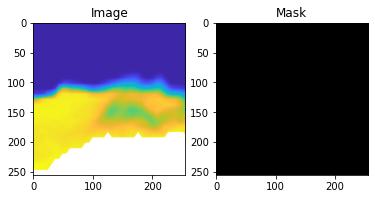

Labels are: [0] and label count is: [65536]
Image Number= 367


In [7]:
# Visualization before preprocessing

img_num = random.randint(0, len(train_images)-1)
V = visualize(train_images, mask_images, img_num)
V

In [8]:
# Preprocessing

X, Y = preprocess_customUnet(train_images,mask_images)

print(X.shape)
print(Y.shape)

(472, 256, 256, 3)
(472, 256, 256, 1)


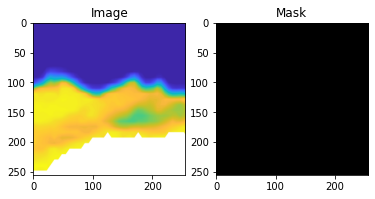

Labels are: [0.] and label count is: [65536]
Image Number= 109


In [9]:
# Visualizing Preprocessed images

img_num = random.randint(0, len(X)-1)
VP = visualize(X,Y, img_num)
VP

In [9]:
# Data Split

x_train, y_train, x_val, y_val = data_split(X, Y, split_size = 0.2, random_state = 42)

print("Train Data Dynamics:" , x_train.shape, y_train.shape)
print("Test Data Dynamics:" , x_val.shape, y_val.shape)

Train Data Dynamics: (377, 256, 256, 3) (377, 256, 256, 1)
Test Data Dynamics: (95, 256, 256, 3) (95, 256, 256, 1)


**Training MultiRes-Unet over 150 Epochs**

In [100]:
# Building MultiRes UNET model

multires_selected = build_multiresunet(input_shape)
multires_selected.compile(optimizer='adam', loss= binary_loss, metrics=[iou])

history_mr_selected = multires_selected.fit(x=x_train, y= y_train, batch_size= BS16, 
                                    epochs= 150, verbose=1, validation_data= (x_val, y_val))

Epoch 1/150
24/24 [==============================] - 29s 933ms/step - loss: 0.6548 - iou_score: 0.0171 - val_loss: 30.6569 - val_iou_score: 0.0118
Epoch 2/150
24/24 [==============================] - 22s 915ms/step - loss: 0.5189 - iou_score: 0.0227 - val_loss: 33.5348 - val_iou_score: 0.0122
Epoch 3/150
24/24 [==============================] - 22s 904ms/step - loss: 0.3860 - iou_score: 0.0253 - val_loss: 29.2317 - val_iou_score: 0.0123
Epoch 4/150
24/24 [==============================] - 21s 893ms/step - loss: 0.2873 - iou_score: 0.0319 - val_loss: 6.4721 - val_iou_score: 0.0148
Epoch 5/150
24/24 [==============================] - 21s 896ms/step - loss: 0.1974 - iou_score: 0.0444 - val_loss: 0.2037 - val_iou_score: 0.0082
Epoch 6/150
24/24 [==============================] - 22s 902ms/step - loss: 0.1657 - iou_score: 0.0553 - val_loss: 0.1757 - val_iou_score: 0.0084
Epoch 7/150
24/24 [==============================] - 22s 900ms/step - loss: 0.1465 - iou_score: 0.0545 - val_loss: 369.68

In [31]:
# Saving model and history
multires.save(f'{saved_models}multires.h5')

In [103]:
# Accuracy
accuracy = model_IOU(multires_selected, x_val, y_val, 0.8)
print('IOU score of model "multires unet model over 150 epochs" is', f'{accuracy:.0%}')

IOU score of model "multires unet model over 150 epochs" is 81%


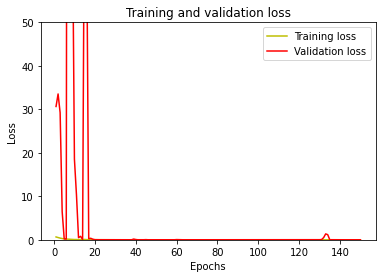

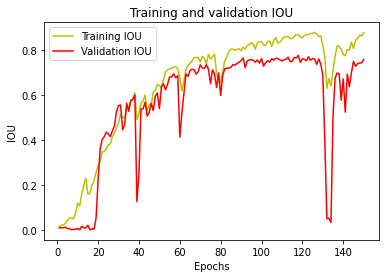

In [105]:
# Evaluation

EV = evaluation(history_mr_selected)

Image Number= 93


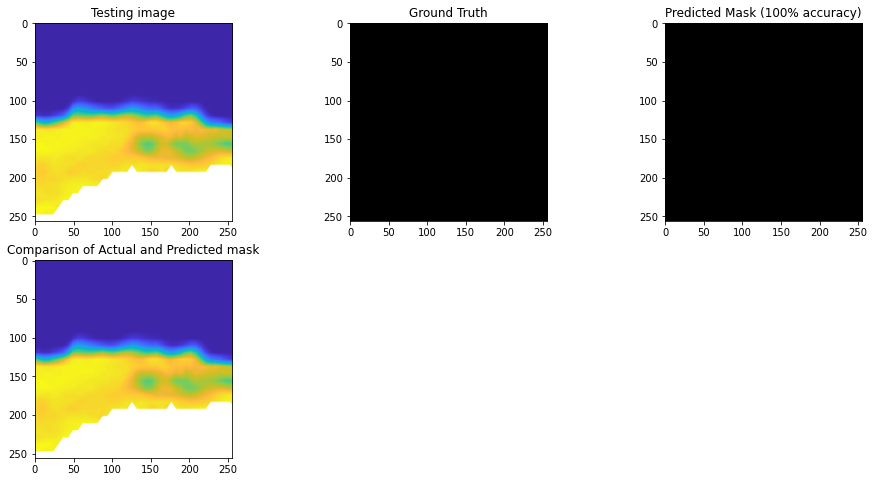

In [200]:
# Performance

img_num = random.randint(0, len(x_val)-1)
perf = performance(x_val, y_val, model = multires_original, threshold=0.8, test_img_number=img_num)

**MultiRes Unet model trained with cross validation**

In [10]:
# Building Model

multires = build_multiresunet(input_shape)
multires.compile(optimizer='adam', loss= binary_loss, metrics=[iou])

In [11]:
# Producing Cross Validation Data Splits

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cvscores1 = []
Fold = 1
for train, val in kfold.split(X, Y):
    
    print ('Fold: ',Fold)

    x_train = X[train]
    x_val = X[val]
    y_train = Y[train]
    y_val = Y[val]

    history1 = multires.fit(x=x_train, y= y_train, batch_size= BS16, 
                                    epochs= 100, verbose=1, validation_data= (x_val, y_val))
    

    # evaluate model for each validation set
    scores = multires.evaluate(x_val, y_val, verbose=0)
    print("%s: %.2f%%" % (multires.metrics_names[1], scores[1]))
    cvscores1.append(scores[1])

    Fold = Fold +1


Fold:  1
Epoch 1/100
24/24 [==============================] - 36s 653ms/step - loss: 0.6641 - iou_score: 0.0128 - val_loss: 0.5623 - val_iou_score: 0.0114
Epoch 2/100
24/24 [==============================] - 11s 451ms/step - loss: 0.5324 - iou_score: 0.0143 - val_loss: 0.4619 - val_iou_score: 0.0118
Epoch 3/100
24/24 [==============================] - 11s 452ms/step - loss: 0.4156 - iou_score: 0.0179 - val_loss: 0.3453 - val_iou_score: 0.0118
Epoch 4/100
24/24 [==============================] - 11s 478ms/step - loss: 0.2998 - iou_score: 0.0293 - val_loss: 34.6294 - val_iou_score: 0.0131
Epoch 5/100
24/24 [==============================] - 11s 452ms/step - loss: 0.2066 - iou_score: 0.0405 - val_loss: 570.9148 - val_iou_score: 0.0121
Epoch 6/100
24/24 [==============================] - 11s 451ms/step - loss: 0.1348 - iou_score: 0.0582 - val_loss: 81.1143 - val_iou_score: 0.0120
Epoch 7/100
24/24 [==============================] - 11s 451ms/step - loss: 0.1119 - iou_score: 0.0744 - val_lo

In [12]:
cvscores1

[0.6109198927879333,
 0.8544741272926331,
 0.8520916104316711,
 0.9164841175079346,
 0.9354804158210754]

In [13]:
# Accuracy
accuracy1 = model_IOU(multires, x_val, y_val, 0.8)
print('IOU score of model "multires unet model with cross validation" is', f'{accuracy1:.0%}')

IOU score of model "multires unet model with cross validation" is 95%


Image Number= 34


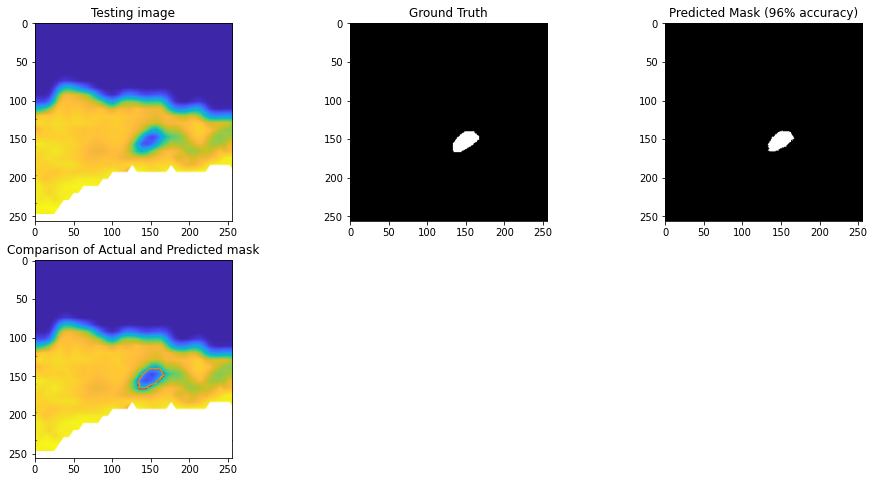

In [16]:
# Performance on Validation dataset

img_num = random.randint(0, len(x_val)-1)
perf = performance(x_val, y_val, model = multires, threshold=0.8, test_img_number=img_num)

In [17]:
# Testing on Unseen Data 

tester_img = load_test_data(test_path, size)
print(tester_img.shape)

(32, 256, 256, 3)


No Polynya Detected


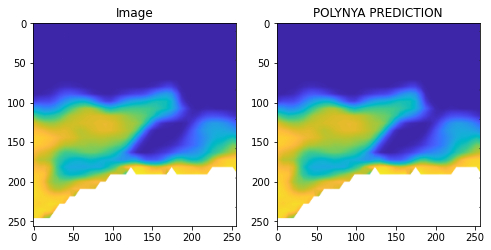

Image number: 29


In [25]:
# Performance on unseen data

img_num = random.randint(0, len(tester_img)-1)
T = testing(tester_img, multires, 0.8, img_num)

**Unet model trained with cross validation**

In [26]:
# Building Model

unet = build_unet(input_shape)
unet.compile(optimizer='adam', loss= binary_loss, metrics=[iou])

In [27]:
# Producing Cross Validation Data Splits

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cvscores2 = []
Fold = 1
for train, val in kfold.split(X, Y):
    
    print ('Fold: ',Fold)

    x_train = X[train]
    x_val = X[val]
    y_train = Y[train]
    y_val = Y[val]

    history2 = unet.fit(x=x_train, y= y_train, batch_size= BS32, 
                                    epochs= 100, verbose=1, validation_data= (x_val, y_val))
    

    # evaluate model for each validation set
    scores = unet.evaluate(x_val, y_val, verbose=0)
    print("%s: %.2f%%" % (unet.metrics_names[1], scores[1]))
    cvscores2.append(scores[1])

    Fold = Fold +1


Fold:  1
Epoch 1/100
12/12 [==============================] - 23s 1s/step - loss: 0.6137 - iou_score: 0.0119 - val_loss: 486.9943 - val_iou_score: 0.0116
Epoch 2/100
12/12 [==============================] - 10s 831ms/step - loss: 0.2114 - iou_score: 0.0130 - val_loss: 15270.5488 - val_iou_score: 0.0118
Epoch 3/100
12/12 [==============================] - 10s 832ms/step - loss: 0.1557 - iou_score: 0.0138 - val_loss: 242.5235 - val_iou_score: 0.0120
Epoch 4/100
12/12 [==============================] - 10s 833ms/step - loss: 0.1397 - iou_score: 0.0138 - val_loss: 131.0987 - val_iou_score: 0.0130
Epoch 5/100
12/12 [==============================] - 10s 833ms/step - loss: 0.1186 - iou_score: 0.0157 - val_loss: 1.7377 - val_iou_score: 0.0148
Epoch 6/100
12/12 [==============================] - 10s 833ms/step - loss: 0.1046 - iou_score: 0.0170 - val_loss: 1.6050 - val_iou_score: 0.0115
Epoch 7/100
12/12 [==============================] - 10s 833ms/step - loss: 0.0946 - iou_score: 0.0183 - val

In [28]:
cvscores2

[0.49694252014160156,
 0.741934597492218,
 0.831199586391449,
 0.8118979334831238,
 0.8103394508361816]

In [29]:
# Accuracy
accuracy2 = model_IOU(unet, x_val, y_val, 0.8)
print('IOU score of model "multires unet model with cross validation" is', f'{accuracy2:.0%}')

IOU score of model "multires unet model with cross validation" is 91%


In [32]:
# Saving model and history
unet.save(f'{saved_models}unet.h5')